<a href="https://colab.research.google.com/github/mikolaj553/Machine-Learning-Homeworks-Repo/blob/main/ml_hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Homework #5 - Mikołaj Kowalewski, lab group no. 1**

Let us start off with generating a synthetic dataset for the purpose of demonstrating various SVM-related phenomena.

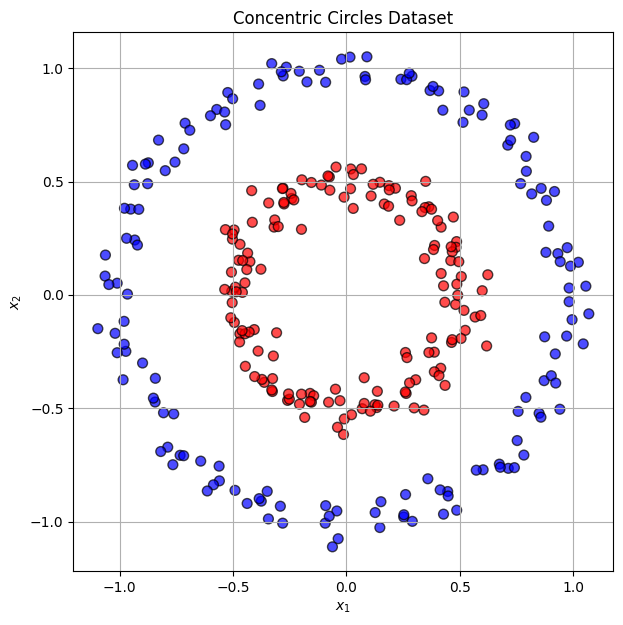

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

# Generating data (concentric circles to have data not linearly seperable in 2D, like the dataset used in class)
np.random.seed(42)
X, y = make_circles(n_samples=300, factor=0.5, noise=0.05)
# Converting labels from (0,1) to (-1,1) for consistency
y = np.where(y == 0, -1, 1)

# Plotting the Data Points
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolors='k', s=50, alpha=0.7)
plt.title('Concentric Circles Dataset')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()


In [25]:
# Defining the explicit mapping phi: ℝ^2 → ℝ^3
def phi(X_in):
    # Mapping: (x1, x2) -> (x1^2, sqrt(2)*x1*x2, x2^2)
    x1 = X_in[:, 0]
    x2 = X_in[:, 1]
    return np.column_stack((x1**2, np.sqrt(2)*x1*x2, x2**2))

# Creating a grid in the original 2D space for decision boundary extraction later
x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]


Next, we define the mapping $$\phi(x_1,x_2) = [x_1^2,\; \sqrt{2}\,x_1x_2,\; x_2^2]$$ which lifts the 2D data into a 3D feature space. We also create a grid in the original 2D space that will be used later for visualizing the decision boundary.


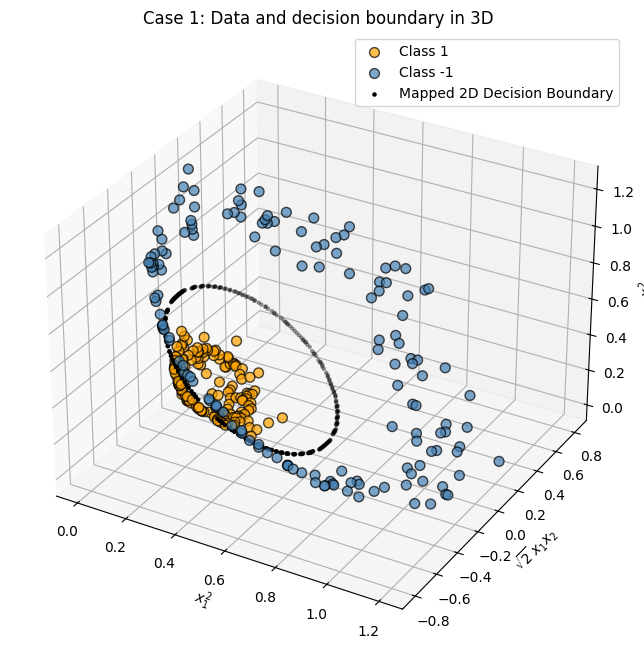

In [30]:
# ======================================================================
# Case 1: Training SVM in 2D with a polynomial kernel and then mapping the decision boundary into 3D
# ======================================================================

# Training the SVM on the original 2D data with a polynomial kernel of degree 2
clf_2D = SVC(kernel='poly', degree=2, C=1.0, coef0=0, gamma=1)
clf_2D.fit(X, y)

# Computing decision function on the grid
decision_vals = clf_2D.decision_function(grid).reshape(xx.shape)

# Extracting 2D decision boundary points (where decision function is near zero)
mask = np.abs(decision_vals) < 0.01
boundary_2D = np.column_stack((xx[mask], yy[mask]))

# Mapping both the original data and the boundary points into 3D
X_3D_case1 = phi(X)
boundary_3D_case1 = phi(boundary_2D)

# Creating a 3D plot for Case 1
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_case1[y==1, 0], X_3D_case1[y==1, 1], X_3D_case1[y==1, 2],
           c='orange', edgecolor='k', s=50, alpha=0.7, label='Class 1')
ax.scatter(X_3D_case1[y==-1, 0], X_3D_case1[y==-1, 1], X_3D_case1[y==-1, 2],
           c='steelblue', edgecolor='k', s=50, alpha=0.7, label='Class -1')
ax.scatter(boundary_3D_case1[:, 0], boundary_3D_case1[:, 1], boundary_3D_case1[:, 2],
           c='k', s=5, label='Mapped 2D Decision Boundary')

ax.set_xlabel('$x_1^2$')
ax.set_ylabel('$\\sqrt{2}\\,x_1x_2$')
ax.set_zlabel('$x_2^2$')
ax.set_title('Case 1: Data and decision boundary in 3D')
ax.legend()
plt.show()


In Case 1 we train an SVM with a polynomial kernel directly on the 2D data. As we have already seen in class, its decision boundary in 2D is nonlinear. We then map both the data points and the extracted 2D decision boundary into the 3D feature space using Φ. The 3D plot above shows that the mapped decision boundary is not a flat plane — it is simply the image of the nonlinear 2D boundary. This is exactly like the situation seen in class.

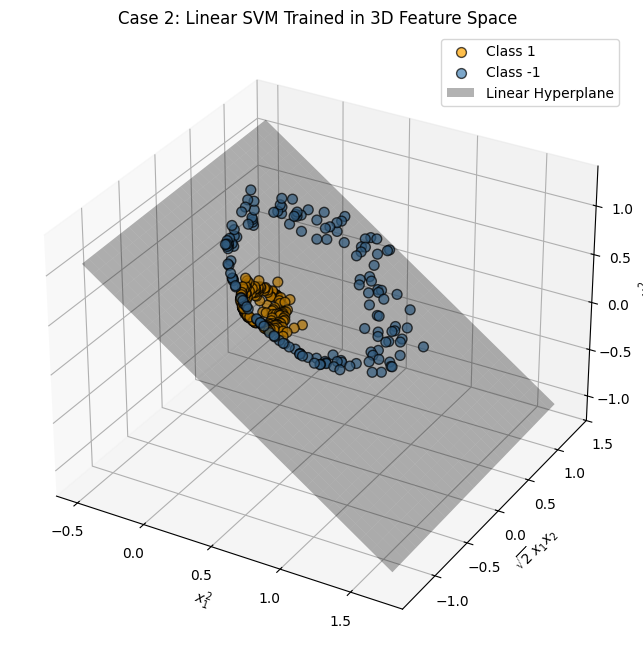

In [31]:
# ======================================================================
# Case 2: Mapping the data to 3D first, then training a Linear SVM
# ======================================================================

# Mapping the original 2D data into 3D using phi
X_3D_case2 = phi(X)

# Training a linear SVM in the 3D feature space
clf_3D = SVC(kernel='linear', C=1e3)
clf_3D.fit(X_3D_case2, y)

# Retrieving the hyperplane parameters: w1*z1 + w2*z2 + w3*z3 + b = 0
w = clf_3D.coef_[0]
b = clf_3D.intercept_[0]

# Creating a mesh in the 3D space for plotting the linear decision hyperplane
z1_min, z1_max = X_3D_case2[:, 0].min() - 0.5, X_3D_case2[:, 0].max() + 0.5
z2_min, z2_max = X_3D_case2[:, 1].min() - 0.5, X_3D_case2[:, 1].max() + 0.5
z1_vals = np.linspace(z1_min, z1_max, 30)
z2_vals = np.linspace(z2_min, z2_max, 30)
Z1, Z2 = np.meshgrid(z1_vals, z2_vals)
# Solving for z3 on the hyperplane: w1*z1 + w2*z2 + w3*z3 + b = 0  =>  z3 = -(w1*z1 + w2*z2 + b)/w3
Z3 = -(w[0]*Z1 + w[1]*Z2 + b) / w[2]

# Plotting the 3D data and the linear SVM hyperplane
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_case2[y==1, 0], X_3D_case2[y==1, 1], X_3D_case2[y==1, 2],
           c='orange', edgecolor='k', s=50, alpha=0.7, label='Class 1')
ax.scatter(X_3D_case2[y==-1, 0], X_3D_case2[y==-1, 1], X_3D_case2[y==-1, 2],
           c='steelblue', edgecolor='k', s=50, alpha=0.7, label='Class -1')
ax.plot_surface(Z1, Z2, Z3, color='black', alpha=0.3, label='Linear Hyperplane')

ax.set_xlabel('$x_1^2$')
ax.set_ylabel('$\\sqrt{2}\\,x_1x_2$')
ax.set_zlabel('$x_2^2$')
ax.set_title('Case 2: Linear SVM Trained in 3D Feature Space')
ax.legend()
plt.show()


In Case 2 we explicitly map the 2D data into the 3D feature space using Φ and then train a linear SVM on the resulting data. The classifier finds a separating hyperplane that is truly linear in the 3D space (and the green surface in the plot is flat).

**Primary Question:** Why does the SVM's decision boundary in the higher-dimensional (3D) feature space not look like a “flat” hyperplane, even though we know the classifier’s separating surface is mathematically linear in that space?

**Answer:**

When we use a polynomial kernel for SVM on our 2D data, the algorithm implicitly operates in a higher-dimensional feature space defined by a mapping such as:

$$
\phi(x_1, x_2) = \bigl( x_1^2,\; \sqrt{2}\,x_1 x_2,\; x_2^2 \bigr).
$$

In this 3D feature space, the new coordinates become

$$
z_1 = x_1^2,\quad z_2 = \sqrt{2}\,x_1 x_2,\quad z_3 = x_2^2.
$$

A linear SVM trained directly in this space finds a hyperplane described by

$$
w_1\,z_1 + w_2\,z_2 + w_3\,z_3 + b = 0,
$$

which is mathematically flat (linear) in the $(z_1, z_2, z_3)$ coordinate system.

However, there is an important geometric detail: the mapping $\phi$ is nonlinear. The operations of squaring the input coordinates and multiplying them together cause a distortion of the geometric structure. When training an SVM in 2D with a polynomial kernel, the resulting decision boundary in the original $(x_1,x_2)$ space is nonlinear. Mapping this 2D decision boundary into the 3D feature space using $\phi$ is transforming a curved boundary into a set of points in $(z_1,z_2,z_3)$ that no longer lie on a flat hyperplane.

However, first mapping all the data using $\phi$ and then training a linear SVM in the 3D feature space will allow one to obtain a hyperplane that is truly flat in that space. The key point is that the geometry imposed by $\phi$ distorts the shape: a nonlinear 2D boundary remains nonlinear when mapped via $\phi$, even though a classifier trained directly in the 3D space would have a flat separating surface.

In summary, while a linear decision boundary is flat in the 3D space of $(z_1,z_2,z_3)$, deriving the boundary in 2D first and then mapping to 3D  using $\phi$, its nonlinear nature remains intact. The nonlinearity in the 3D visualization is a direct consequence of the nonlinear geometry of the mapping $\phi$.

Let us now move on to the secondary question.


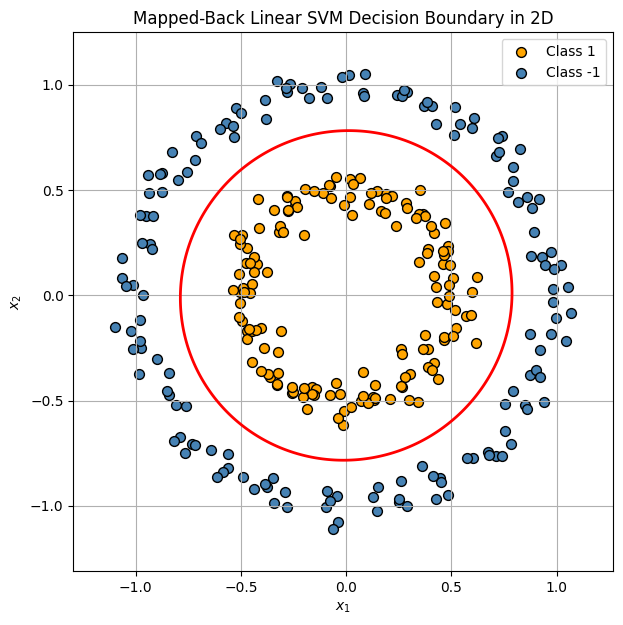

In [29]:
# Now, we map the hyperplane back to 2D by substituting:
#   z1 = x1^2,  z2 = sqrt(2)*x1*x2,  z3 = x2^2
# into the hyperplane equation: w1*z1 + w2*z2 + w3*z3 + b = 0
#
# This yields the quadratic equation in terms of x1 and x2:
#   f(x1, x2) = w1*x1^2 + w2*sqrt(2)*x1*x2 + w3*x2^2 + b = 0

# Creating a grid over the original 2D space
x1_min, x1_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
x2_min, x2_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x1_min, x1_max, 300),
                     np.linspace(x2_min, x2_max, 300))

# Evaluating the quadratic decision function on the grid:
# f(x1, x2) = w1*x1^2 + w2*sqrt(2)*x1*x2 + w3*x2^2 + b
decision_2D = w[0]*xx**2 + w[1]*np.sqrt(2)*xx*yy + w[2]*yy**2 + b

# Plotting the original 2D data and the decision boundary defined by the quadratic equation
plt.figure(figsize=(10, 7))
plt.scatter(X[y==1, 0], X[y==1, 1], color='orange', edgecolors='k', s=50, label='Class 1')
plt.scatter(X[y==-1, 0], X[y==-1, 1], color='steelblue', edgecolors='k', s=50, label='Class -1')

# Plotting the contour where the decision function equals zero
plt.contour(xx, yy, decision_2D, levels=[0], linewidths=2, colors='red')

plt.title('Mapped-Back Linear SVM Decision Boundary in 2D')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal')
plt.show()

**Secondary question:** Explain why a hyperplane in 3D becomes a circular (or elliptical) curve when viewed back in the original 2D plane of the dataset.

**Answer:** When we train a linear SVM in the 3D feature space, we obtain a hyperplane described by the equation

$$
w_1\,z_1 + w_2\,z_2 + w_3\,z_3 + b = 0,
$$

where the coordinates in this space are given by

$$
z_1 = x_1^2,\quad z_2 = \sqrt{2}\,x_1x_2,\quad z_3 = x_2^2.
$$

If we substitute these expressions back into the hyperplane equation, we obtain

$$
w_1\,x_1^2 + w_2\,\sqrt{2}\,x_1x_2 + w_3\,x_2^2 + b = 0.
$$

This is a quadratic equation in the original variables $x_1$ and $x_2$. Geometrically, quadratic equations in two dimensions represent conic sections, such as circles or ellipses. Thus, when we map the flat hyperplane from the 3D feature space back into the original 2D space, its representation becomes a circular (or elliptical) curve.

The important point is that the mapping

$$
\phi(x_1, x_2) = \bigl( x_1^2,\; \sqrt{2}\, x_1x_2,\; x_2^2 \bigr)
$$

is nonlinear. Although the SVM finds a flat (linear) hyperplane in the 3D space of $(z_1,z_2,z_3)$, the nonlinear nature of $\phi$ transforms that hyperplane into a quadratic curve when expressed in the original $(x_1,x_2)$ space. This is why, despite the linearity in the feature space, the mapped-back decision boundary appears as a curved, elliptical or circular boundary (as in our case) in 2D.